In [2]:
import ipyparallel as ipp

rc = ipp.Client(profile="bluefog")
dview = rc[:]  # A DirectView of all engines
dview.block = True
rc.ids

[0, 1, 2, 3, 4]

In [3]:
%%px
import bluefog.torch as bf
from bluefog.common import topology_util
import networkx as nx

bf.init()
message = f"Hello, I am {bf.rank()} among {bf.size()} processes"
print(message)

[stdout:2] Hello, I am 0 among 5 processes


[stdout:4] Hello, I am 2 among 5 processes


[stdout:1] Hello, I am 4 among 5 processes


[stdout:0] Hello, I am 1 among 5 processes


[stderr:2] Invalid MIT-MAGIC-COOKIE-1 key

[stderr:1] Invalid MIT-MAGIC-COOKIE-1 key

[stdout:3] Hello, I am 3 among 5 processes


[stderr:4] Invalid MIT-MAGIC-COOKIE-1 key

[stderr:0] Invalid MIT-MAGIC-COOKIE-1 key

[stderr:3] Invalid MIT-MAGIC-COOKIE-1 key

In [4]:
import os
import sys
import numpy as np

import config
foldname = config.foldname

sys.path.append('/home/yl-02/下载/experiments-main')
from lib.function import param_est

X_opt = np.load(foldname+'data_X_0.npy')
U = np.load( foldname + 'data_U.npy' )
E = np.load( foldname + 'data_E.npy' )

/home/yl-02/下载/experiments-main/experiment/param_est/data/


In [5]:
#数据分配
num_nodes = len(rc.ids)

samples= U.shape[0]
num_split = int(samples // num_nodes)
for i in range(num_nodes):
    data = U[i * num_split : (i + 1) * num_split]
    noise = E[i * num_split : (i + 1) * num_split]
    dview.push({"data": data}, targets=i)
    dview.push({"noise": noise}, targets=i)

dview.push({"X_opt": X_opt})

[None, None, None, None, None]

In [6]:
%%px
import os
import sys

sys.path.append('/home/yl-02/下载/experiments-main')
import numpy as np
from core.online_problem import OnlineProblem
from lib.function import param_est
from solver.stochastic_GTA import *

sys.path.append('/home/yl-02/下载/experiments-main/experiment/pca_Stf/waveform')
import config


n=config.n
T=config.T
block=config.block
foldname = config.foldname
St =config.mfd
X_0 = config.X_0
y_0 = config.y_0

#graph
node = bf.size()    #number of nodes
G = topology_util.StarGraph(node)
bf.set_topology(G)

ol_problem = OnlineProblem(     mfd = St,
                                data = data,
                                time = T,
                                alpha = config.alpha,
                                beta = config.beta,
                                eta = noise,
                                loss = param_est.grad,
                                grad = param_est.pgrad,
                                ) 

solver = StochasticGTA()
solver.optimize(ol_problem,X_0, y_0, X_opt)

print('gradient solver completed')

[stdout:1] /home/yl-02/下载/experiments-main/experiment/param_est/data/
gradient solver completed


[stdout:2] /home/yl-02/下载/experiments-main/experiment/param_est/data/
gradient solver completed


[stdout:0] /home/yl-02/下载/experiments-main/experiment/param_est/data/
gradient solver completed


[stdout:3] /home/yl-02/下载/experiments-main/experiment/param_est/data/
gradient solver completed


[stdout:4] /home/yl-02/下载/experiments-main/experiment/param_est/data/
gradient solver completed


%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

In [7]:
sys.path.append('/home/yl-02/下载/experiments-main')
from solver.stochastic_GTA import *

solver = StochasticGTA()
# value_SGTA = dview.pull("solver.op_histories", block=True, targets=0)
# grad_SGTA = dview.pull("solver.grad_norm_his", block=True, targets=0)
oracle_SGTA = dview.pull("solver.oracle", block=True, targets=0)
hat_SGTA = dview.pull("solver.X_hat", block=True, targets=0)
grad_SGTA = list()
value_SGTA = list()
for i in range(len(hat_SGTA)):
    grad = param_est.grad(hat_SGTA[i], num_nodes)
    g_norm = np.linalg.norm(grad)
    loss = param_est.func(hat_SGTA[i], num_nodes)
    grad_SGTA.append(g_norm)
    value_SGTA.append(loss)
    

np.save( foldname + 'value_SGTA',value_SGTA)
np.save( foldname + 'grad_SGTA',grad_SGTA)
np.save( foldname+ 'oracle_SGTA',oracle_SGTA)
np.save( foldname + 'hat_SGTA',hat_SGTA)

In [8]:
%%px
from solver.DR_SGD import *

n=config.n
T=config.T
block=config.block
foldname = config.foldname
St =config.mfd
X_0 = config.X_0

#graph
node = bf.size()    #number of nodes
G = topology_util.StarGraph(node)
bf.set_topology(G)

ol_problem = OnlineProblem(     mfd = St,
                                data = data,
                                time = T,
                                alpha = config.alpha,
                                beta = config.beta,
                                eta = noise,
                                loss = param_est.grad,
                                grad = param_est.pgrad,
                                ) 

solver =DR_SGD()
solver.optimize(ol_problem,X_0, X_opt)

print('gradient solver completed')

[stdout:2] gradient solver completed


[stdout:4] gradient solver completed


[stdout:3] gradient solver completed


[stdout:1] gradient solver completed


[stdout:0] gradient solver completed


In [9]:
from solver.DR_SGD import *

solver = DR_SGD()
# value_SGD= dview.pull("solver.op_histories", block=True, targets=0)
# grad_SGD = dview.pull("solver.grad_norm_his", block=True, targets=0)
oracle_SGD = dview.pull("solver.oracle", block=True, targets=0)
hat_SGD = dview.pull("solver.X_hat", block=True, targets=0)
grad_SGD = list()
value_SGD = list()
for i in range(len(hat_SGTA)):
    grad = param_est.grad(hat_SGD[i], num_nodes)
    g_norm = np.linalg.norm(grad)
    loss = param_est.func(hat_SGD[i], num_nodes)
    grad_SGD.append(g_norm)
    value_SGD.append(loss)

np.save( foldname + 'value_SGD',value_SGD)
np.save( foldname + 'grad_SGD',grad_SGD)
np.save( foldname+ 'oracle_SGD',oracle_SGD)
np.save( foldname + 'hat_SGD',hat_SGD)

In [10]:
%%px
from solver.cons_sample import *

n=config.n
T=config.T
block=config.block
foldname = config.foldname
St =config.mfd
X_0 = config.X_0
y_0 = config.y_0

#graph
node = bf.size()    #number of nodes
G = topology_util.StarGraph(node)
bf.set_topology(G)

ol_problem = OnlineProblem(     mfd = St,
                                data = data,
                                time = T,
                                alpha = config.alpha,
                                beta = config.beta,
                                eta = noise,
                                loss = param_est.grad,
                                grad = param_est.pgrad,
                                ) 

solver = ConsSample()
solver.optimize(ol_problem,X_0, y_0, X_opt)

print('gradient solver completed')

%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

[stdout:3] gradient solver completed


[stdout:1] gradient solver completed


[stdout:4] gradient solver completed


[stdout:2] gradient solver completed


[stdout:0] gradient solver completed


In [11]:
from solver.cons_sample import *

solver = ConsSample()
# value_cons = dview.pull("solver.op_histories", block=True, targets=0)
# grad_cons = dview.pull("solver.grad_norm_his", block=True, targets=0)
oracle_cons = dview.pull("solver.oracle", block=True, targets=0)
hat_cons = dview.pull("solver.X_hat", block=True, targets=0)
grad_cons = list()
value_cons = list()
for i in range(len(hat_SGTA)):
    grad = param_est.grad(hat_cons[i], num_nodes)
    g_norm = np.linalg.norm(grad)
    loss = param_est.func(hat_cons[i], num_nodes)
    grad_cons.append(g_norm)
    value_cons.append(loss)

np.save( foldname + 'value_cons',value_cons)
np.save( foldname + 'grad_cons',grad_cons)
np.save( foldname+ 'oracle_cons',oracle_cons)
np.save( foldname+ 'hat_cons',oracle_cons)

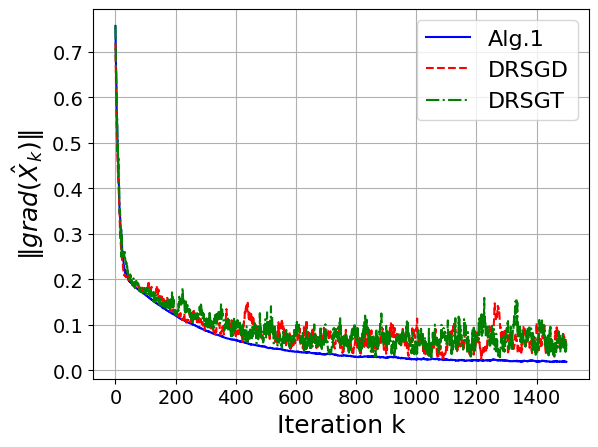

In [14]:
#plot
import sys
sys.path.append('.')

from lib.operation.calculate_gap import cal_gap
from lib.operation.figureplot import *
import matplotlib.pyplot as plt
import numpy as np
import config


foldname = config.foldname
res= load_data(foldname)
grid = list(np.arange(config.T))
# opt = param_est.func(X_opt, num_nodes)
# cal_gap(res, opt)
plot_grad(res,grid)
plt.show()